
## Evaluating the performance of a hybrid power plant with P2X using HyDesign

In this notebook we will evaluate a hybrid power plant design in a specific location.

A hybrid power plant design consists on selecting the following parameters:

**Wind Plant design:**

1. Number of wind turbines in the wind plant [-] (`Nwt`)
2. Wind power installation density [MW/km2] (`wind_MW_per_km2`): This parameter controls how closely spaced are the turbines, which in turns affect how much wake losses are present.

**PV Plant design:**

3. Solar plant power capacity [MW] (`solar_MW`)

**Battery Storage design:**

4. Battery power [MW] (`b_P`)
5. Battery energy capacity in hours [MWh] (`b_E_h `): Battery storage capacity in hours of full battery power (`b_E = b_E_h * b_P `). 
6. Cost of battery power fluctuations in peak price ratio [-] (`cost_of_batt_degr`): This parameter controls how much penalty is given to do ramps in battery power in the HPP operation.

**Electrolyzer design:**

7. Electrolyzer capacity [MW] (`ptg_MW`)
8. H2 storage capacity [kg] (`HSS_kg`)

##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# Detect if running in Kaggle
import os 
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    mypaths = !python -c "import sysconfig; print(sysconfig.get_paths()['purelib'])"
    mypath = mypaths[0]
    !pip install trash-cli
    !trash $mypath/numpy*
    !pip install --upgrade numpy
    !pip install finitediff
    import os
    os.kill(os.getpid(), 9)

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [1]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydesign.hpp_assembly_P2X import hpp_model_P2X
from hydesign.examples import examples_filepath

##
**Specifying the site**

Hydesign, provides example data from several sites in India and Europe. 

The site coordinates (longitude, latitude, and altitude) are given in `examples_sites.csv`.

In [2]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0)
examples_sites

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/input_ts_Indian_site_bad_solar_bad_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv


##
**Select a site to run**

In [3]:
name = 'Denmark_good_wind'

ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

In [4]:
# Weather data and Price data
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]

input_ts = pd.read_csv(input_ts_fn, index_col=0, parse_dates=True)

required_cols = [col for col in input_ts.columns if 'WD' not in col]
input_ts = input_ts.loc[:,required_cols]
input_ts

,WS_1,WS_50,WS_100,WS_150,WS_200,temp_air_1,ghi,dni,dhi,Price
2012-01-01 00:00:00,3.288440,8.417390,10.213819,11.600266,13.410397,276.767325,0.035121,0.0,0.035121,32.158
2012-01-01 01:00:00,3.274595,8.398900,10.193205,11.776955,13.505000,277.374423,0.017560,0.0,0.017560,32.158
2012-01-01 02:00:00,3.562195,8.909059,10.765491,12.512967,14.097999,278.015879,0.000000,0.0,0.000000,32.158
2012-01-01 03:00:00,3.994770,9.681503,11.634468,13.791528,15.302164,278.655888,0.000000,0.0,0.000000,32.158
2012-01-01 04:00:00,4.280727,10.094911,12.071632,14.358765,15.676826,279.290819,0.000000,0.0,0.000000,32.158
...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,6.982550,15.994200,19.028254,21.861165,23.342218,280.869008,0.000000,0.0,0.000000,35.446
2012-12-31 20:00:00,6.701203,15.384391,18.312855,21.021135,22.469301,280.877234,0.000000,0.0,0.000000,33.565
2012-12-31 21:00:00,6.250792,14.444226,17.213032,19.796159,21.174110,280.891512,0.000000,0.0,0.000000,32.709
2012-12-31 22:00:00,5.121517,11.980019,14.307815,16.421864,17.590641,280.635464,0.000000,0.0,0.000000,31.392


In [9]:
# Hydrogen demand data, when H2 offtake is infinite -> make H2_demand values very high (1e6) in H2_demand.csv file and penalty_H2 as '0' in hpp_pars.yml file
H2_demand_fn = examples_filepath+ex_site['H2_demand_col'].values[0]

H2_demand_ts = pd.read_csv(H2_demand_fn, index_col=0, parse_dates=True)
H2_demand_ts

,H2_demand
2012-01-01 00:00:00,1500
2012-01-01 01:00:00,1500
2012-01-01 02:00:00,1500
2012-01-01 03:00:00,1500
2012-01-01 04:00:00,1500
...,...
2012-12-31 19:00:00,1500
2012-12-31 20:00:00,1500
2012-12-31 21:00:00,1500
2012-12-31 22:00:00,1500


In [11]:
# Input data of technology's cost
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]

with open(sim_pars_fn) as file:
    sim_pars = yaml.load(file, Loader=yaml.FullLoader)

print(sim_pars_fn)    
sim_pars

c:/users/gupta/hydesign/hydesign/examples/Europe/hpp_pars.yml


{'G_MW': 300,
 'year': '2012',
 'N_life': 25,
 'wind_turbine_cost': 640000,
 'wind_civil_works_cost': 260000,
 'wind_fixed_onm_cost': 12600,
 'wind_variable_onm_cost': 1.35,
 'wpp_efficiency': 1.0,
 'd_ref': 145,
 'hh_ref': 100,
 'p_rated_ref': 5.0,
 'solar_PV_cost': 110000,
 'solar_hardware_installation_cost': 100000,
 'solar_inverter_cost': 20000,
 'solar_fixed_onm_cost': 4500,
 'pv_deg_per_year': 0.005,
 'land_use_per_solar_MW': 0.01226,
 'tracking': 'No',
 'battery_energy_cost': 45000,
 'battery_power_cost': 16000,
 'battery_BOP_installation_commissioning_cost': 18000,
 'battery_control_system_cost': 4500,
 'battery_energy_onm_cost': 0,
 'battery_depth_of_discharge': 0.9,
 'battery_charge_efficiency': 0.98,
 'battery_price_reduction_per_year': 0.1,
 'n_steps_in_LoH': 20,
 'min_LoH': 0.7,
 'n_full_power_hours_expected_per_day_at_peak_price': 0,
 'peak_hr_quantile': 0.9,
 'price_H2': 5,
 'storage_eff': 0.9,
 'ptg_deg': 0.99,
 'hhv': 39.3,
 'water_consumption': 9.4,
 'electrolyzer_cap

## 
**Initializing the HPP model**

Initialize the HPP model (hpp_model class) with the coordinates and the necessary input files.

In [12]:
hpp = hpp_model_P2X(
        latitude,
        longitude,
        altitude,
        num_batteries = 3,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
        H2_demand_fn = H2_demand_fn, 
)

longitude = 8.594398
latitude = 56.227322
altitude = 85.0


##
### Evaluating the HPP model

In [17]:
start = time.time()

clearance = 10
sp = 360
p_rated = 4        
Nwt = 90
wind_MW_per_km2 = 5
solar_MW = 80
surface_tilt = 50
surface_azimuth = 210
DC_AC_ratio = 1.5
b_P = 20
b_E_h  = 4
cost_of_batt_degr = 10
ptg_MW = 150
HSS_kg = 3000

x = [clearance, sp, p_rated, Nwt, wind_MW_per_km2, solar_MW, \
surface_tilt, surface_azimuth, DC_AC_ratio, b_P, b_E_h , cost_of_batt_degr, ptg_MW, HSS_kg]

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 360.000
p_rated [MW]: 4.000
Nwt: 90.000
wind_MW_per_km2 [MW/km2]: 5.000
solar_MW [MW]: 80.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 210.000
DC_AC_ratio: 1.500
b_P [MW]: 20.000
b_E_h [h]: 4.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000
ptg_MW [MW]: 150.000
HSS_kg [kg]: 3000.000


NPV_over_CAPEX: 0.425
NPV [MEuro]: 184.915
IRR: 0.097
LCOE [Euro/MWh]: 24.807
LCOH [Euro/kg]: 4.548
Revenue [MEuro]: 1823.131
CAPEX [MEuro]: 434.947
OPEX [MEuro]: 9.188
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 1359.116
annual_Power2Grid [GWh]: 644.075
GUF: 0.517
annual_H2 [tons]: 10187.347
annual_P_ptg [GWh]: 715.041
grid [MW]: 300.000
wind [MW]: 360.000
solar [MW]: 80.000
PtG [MW]: 150.000
HSS [kg]: 3000.000
Battery Energy [MWh]: 80.000
Battery Power [MW]: 20.000
Total curtailment [GWh]: 0.000
Awpp [km2]: 72.000
Apvp [km2]: 0.981
Rotor diam [m]: 118.942
Hub height [m]: 69.471
Number of batteries used in lifetime: 3.000

exec. tim

##
### Plot the HPP operation

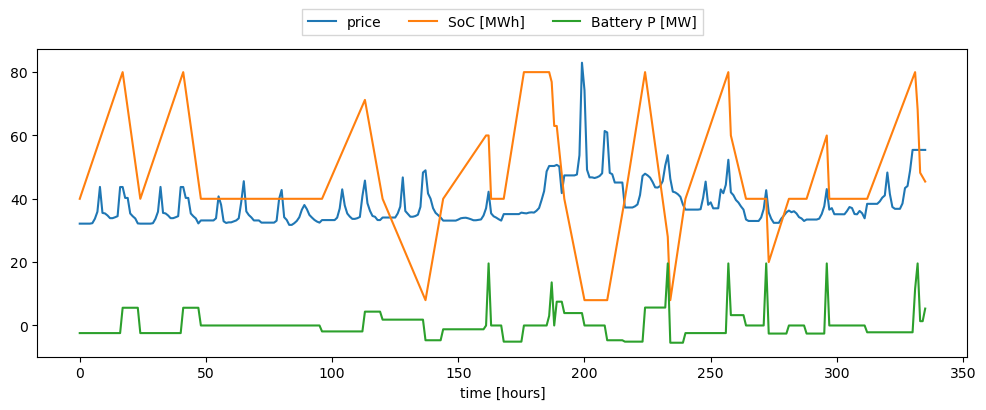

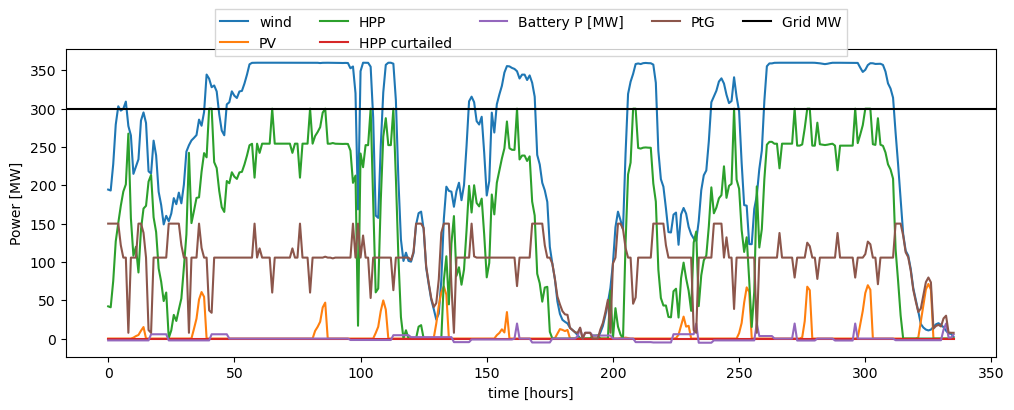

In [14]:
b_E_SOC_t = hpp.prob.get_val('ems_P2X.b_E_SOC_t')
b_t = hpp.prob.get_val('ems_P2X.b_t')
price_t = hpp.prob.get_val('ems_P2X.price_t')

wind_t = hpp.prob.get_val('ems_P2X.wind_t')
solar_t = hpp.prob.get_val('ems_P2X.solar_t')
hpp_t = hpp.prob.get_val('ems_P2X.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems_P2X.hpp_curt_t')
P_ptg_t = hpp.prob.get_val('ems_P2X.P_ptg_t')
grid_MW = hpp.prob.get_val('ems_P2X.G_MW')

n_days_plot = 14
plt.figure(figsize=[12,4])
plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
plt.plot(wind_t[:24*n_days_plot], label='wind')
plt.plot(solar_t[:24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
plt.plot(b_t[:24*n_days_plot], label='Battery P [MW]')
plt.plot(P_ptg_t[:24*n_days_plot], label='PtG')
plt.axhline(grid_MW, label='Grid MW', color='k')
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)


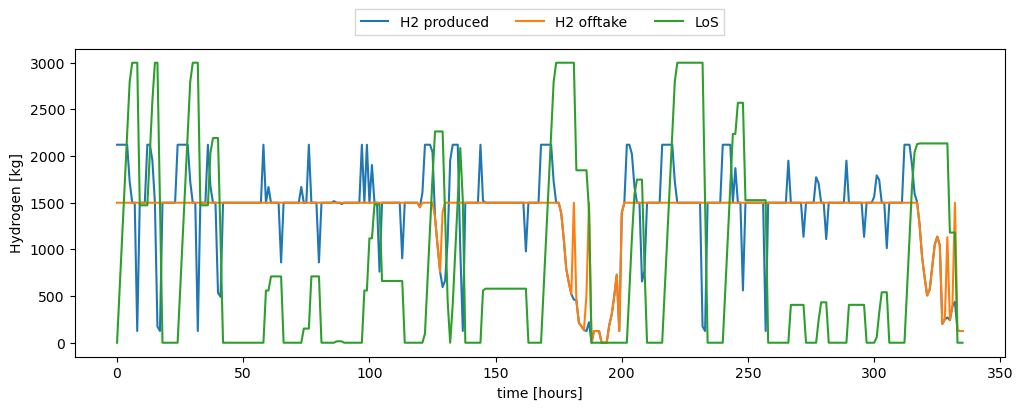

In [15]:
m_H2_t = hpp.prob.get_val('ems_P2X.m_H2_t')
m_H2_demand_t = hpp.prob.get_val('ems_P2X.m_H2_demand_t_ext')
m_H2_offtake_t = hpp.prob.get_val('ems_P2X.m_H2_offtake_t')
LoS_H2_t = hpp.prob.get_val('ems_P2X.LoS_H2_t')

plt.figure(figsize=[12,4])
plt.plot(m_H2_t[:24*n_days_plot], label='H2 produced')
plt.plot(m_H2_offtake_t[:24*n_days_plot], label='H2 offtake')
#plt.plot(m_H2_demand_t[:24*n_days_plot], label='H2 demand')
plt.plot(LoS_H2_t[:24*n_days_plot], label='LoS')
plt.xlabel('time [hours]')
plt.ylabel('Hydrogen [kg]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)

<Figure size 1600x600 with 0 Axes>

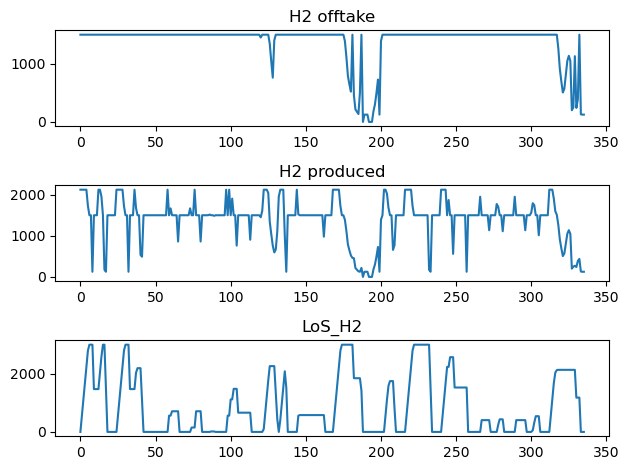

In [16]:
# Create a figure and a grid of subplots
plt.figure(figsize=[16,6])
fig, axes = plt.subplots(nrows=3, ncols=1)

# Now you can use the axes to create individual plots
axes[0].plot(m_H2_offtake_t[:24*n_days_plot])
axes[0].set_title('H2 offtake')

axes[1].plot(m_H2_t[:24*n_days_plot])
axes[1].set_title('H2 produced')

axes[2].plot(LoS_H2_t[:24*n_days_plot])
axes[2].set_title('LoS_H2')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
